In [2]:
from google.colab import files
uploaded = files.upload()

Saving training.zip to training.zip


In [3]:
!unzip training.zip

Streaming output truncated to the last 5000 lines.
  inflating: training/5/Training_40338708.jpg  
  inflating: __MACOSX/training/5/._Training_40338708.jpg  
  inflating: training/5/Training_75609455.jpg  
  inflating: __MACOSX/training/5/._Training_75609455.jpg  
  inflating: training/5/Training_87214996.jpg  
  inflating: __MACOSX/training/5/._Training_87214996.jpg  
  inflating: training/5/Training_42271571.jpg  
  inflating: __MACOSX/training/5/._Training_42271571.jpg  
  inflating: training/5/Training_48177875.jpg  
  inflating: __MACOSX/training/5/._Training_48177875.jpg  
  inflating: training/5/Training_13225185.jpg  
  inflating: __MACOSX/training/5/._Training_13225185.jpg  
  inflating: training/5/Training_7247576.jpg  
  inflating: __MACOSX/training/5/._Training_7247576.jpg  
  inflating: training/5/Training_92910617.jpg  
  inflating: __MACOSX/training/5/._Training_92910617.jpg  
  inflating: training/5/Training_81106041.jpg  
  inflating: __MACOSX/training/5/._Training_811

In [4]:
!ls

__MACOSX  sample_data  training  training.zip


In [5]:
!ls training/

0  1  2  3  4  5


In [6]:
!pip install keras
!pip install tensorflow
!pip install --upgrade keras tensorflow
!pip install --upgrade opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.1 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: keras
    Found existing installation: keras 3.10.0
    Uninstalling keras-3.10.0:
      Successfully uninstalled keras-3.10.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is incom

#### Importing Libraries

In [8]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools
import json
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

#### Config

In [9]:
ORIGINAL_DATASET = "training"  # folder with all images in class subfolders
DATA_ROOT = "dataset"           # folder where train/val/test will be created
IMG_SIZE = (48, 48)
BATCH_SIZE = 64
EPOCHS = 30
COLOR_MODE = "grayscale"       # 'grayscale' or 'rgb'
MODEL_SAVE_PATH = "emotion_model_best.h5"
HISTORY_PLOT = "training_history.png"
CONF_MATRIX_PLOT = "confusion_matrix.png"
RANDOM_SEED = 42
SPLIT_RATIO = (0.7, 0.15, 0.15)  # train/val/test

In [10]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

#### Split dataset into train/val/test

In [11]:
def split_dataset(src_folder, dest_root, split_ratio=(0.7,0.15,0.15)):
    os.makedirs(dest_root, exist_ok=True)
    sets = ["train", "val", "test"]

    for s in sets:
        os.makedirs(os.path.join(dest_root, s), exist_ok=True)

    classes = [d for d in os.listdir(src_folder) if os.path.isdir(os.path.join(src_folder, d))]
    print("Found classes:", classes)

    for cls in classes:
        cls_src = os.path.join(src_folder, cls)
        images = os.listdir(cls_src)
        random.shuffle(images)
        n_total = len(images)
        n_train = int(n_total * split_ratio[0])
        n_val = int(n_total * split_ratio[1])

        cls_dest_train = os.path.join(dest_root, "train", cls)
        cls_dest_val = os.path.join(dest_root, "val", cls)
        cls_dest_test = os.path.join(dest_root, "test", cls)
        os.makedirs(cls_dest_train, exist_ok=True)
        os.makedirs(cls_dest_val, exist_ok=True)
        os.makedirs(cls_dest_test, exist_ok=True)

        for i, img in enumerate(images):
            src_img_path = os.path.join(cls_src, img)
            if i < n_train:
                shutil.copy2(src_img_path, cls_dest_train)
            elif i < n_train + n_val:
                shutil.copy2(src_img_path, cls_dest_val)
            else:
                shutil.copy2(src_img_path, cls_dest_test)

split_dataset(ORIGINAL_DATASET, DATA_ROOT, SPLIT_RATIO)

TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR   = os.path.join(DATA_ROOT, "val")
TEST_DIR  = os.path.join(DATA_ROOT, "test")

Found classes: ['3', '2', '0', '1', '4', '5']


#### Data generators

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED
)

validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print("Detected classes:", train_generator.class_indices)
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 1 if COLOR_MODE == "grayscale" else 3)

Found 10821 images belonging to 6 classes.
Found 2317 images belonging to 6 classes.
Found 2326 images belonging to 6 classes.
Detected classes: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}


#### Class weights

In [13]:
y_train_classes = train_generator.classes
cw = compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)
class_weights = {i: cw[i] for i in range(len(cw))}
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.9582890541976621), 1: np.float64(1.0522170361726955), 2: np.float64(0.9806960304513322), 3: np.float64(0.9801630434782609), 4: np.float64(1.029982866933181), 5: np.float64(1.0047353760445683)}


#### Model

In [14]:
def build_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

model = build_model(input_shape, num_classes)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,971,526 (18.96 MB)

 Trainable params: 4,968,774 (18.95 MB)

 Non-trainable params: 2,752 (10.75 KB)

#### Compile

In [15]:
model.compile(
    optimizer=Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

#### Callbacks

In [16]:
callbacks = [
    ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
]

#### Train

In [17]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    class_weight=class_weights
)

model.save("emotion_model_final.h5")

with open("class_indices.json", "w") as f:
    json.dump(train_generator.class_indices, f, indent=2)

Epoch 1/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2228 - loss: 2.6424 - precision: 0.2326 - recall: 0.1357
Epoch 1: val_accuracy improved from None to 0.16573, saving model to emotion_model_best.h5


170/170 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.2300 - loss: 2.3849 - precision: 0.2495 - recall: 0.1253 - val_accuracy: 0.1657 - val_loss: 4.9219 - val_precision: 0.1657 - val_recall: 0.1657 - learning_rate: 0.0010
Epoch 2/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2605 - loss: 2.0341 - precision: 0.3228 - recall: 0.1226
Epoch 2: val_accuracy improved from 0.16573 to 0.16659, saving model to emotion_model_best.h5


170/170 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.2739 - loss: 1.9670 - precision: 0.3448 - recall: 0.1248 - val_accuracy: 0.1666 - val_loss: 2.9667 - val_precision: 0.1696 - val_recall: 0.1588 - learning_rate: 0.0010
Epoch 3/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3152 - loss: 1.7900 - precision: 0.4331 - recall: 0.1328
Epoch 3: val_accuracy improved from 0.16659 to 0.25507, saving model to emotion_model_best.h5


170/170 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.3264 - loss: 1.7542 - precision: 0.4568 - recall: 0.1425 - val_accuracy: 0.2551 - val_loss: 1.9498 - val_precision: 0.3107 - val_recall: 0.0928 - learning_rate: 0.0010
Epoch 4/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3573 - loss: 1.6626 - precision: 0.5039 - recall: 0.1621
Epoch 4: val_accuracy improved from 0.25507 to 0.36470, saving model to emotion_model_best.h5


170/170 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.3570 - loss: 1.6438 - precision: 0.5099 - recall: 0.1636 - val_accuracy: 0.3647 - val_loss: 1.7328 - val_precision: 0.5404 - val_recall: 0.1731 - learning_rate: 0.0010
Epoch 5/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3904 - loss: 1.5599 - precision: 0.5464 - recall: 0.1785
Epoch 5: val_accuracy improved from 0.36470 to 0.40699, saving model to emotion_model_best.h5


170/170 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.3928 - loss: 1.5414 - precision: 0.5669 - recall: 0.1904 - val_accuracy: 0.4070 - val_loss: 1.5084 - val_precision: 0.5933 - val_recall: 0.1990 - learning_rate: 0.0010
Epoch 6/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4076 - loss: 1.4826 - precision: 0.6228 - recall: 0.2032
Epoch 6: val_accuracy improved from 0.40699 to 0.46612, saving model to emotion_model_best.h5


170/170 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.4130 - loss: 1.4668 - precision: 0.6184 - recall: 0.2073 - val_accuracy: 0.4661 - val_loss: 1.3824 - val_precision: 0.6623 - val_recall: 0.2633 - learning_rate: 0.0010
Epoch 7/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4344 - loss: 1.4251 - precision: 0.6208 - recall: 0.2171
Epoch 7: val_accuracy did not improve from 0.46612
170/170 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.4402 - loss: 1.4153 - precision: 0.6374 - recall: 0.2214 - val_accuracy: 0.4614 - val_loss: 1.3980 - val_precision: 0.6221 - val_recall: 0.2913 - learning_rate: 0.0010
Epoch 8/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4589 - loss: 1.3792 - precision: 0.6538 - recall: 0.2522
Epoch 8: val_accuracy improved from 0.46612 to 0.47216, saving model to emotion_model_best.h5


170/170 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.4534 - loss: 1.3803 - precision: 0.6506 - recall: 0.2495 - val_accuracy: 0.4722 - val_loss: 1.3695 - val_precision: 0.6567 - val_recall: 0.2948 - learning_rate: 0.0010
Epoch 9/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4577 - loss: 1.3701 - precision: 0.6562 - recall: 0.2482
Epoch 9: val_accuracy improved from 0.47216 to 0.49417, saving model to emotion_model_best.h5


170/170 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.4664 - loss: 1.3589 - precision: 0.6608 - recall: 0.2580 - val_accuracy: 0.4942 - val_loss: 1.3699 - val_precision: 0.6628 - val_recall: 0.3189 - learning_rate: 0.0010
Epoch 10/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4733 - loss: 1.3548 - precision: 0.6439 - recall: 0.2628
Epoch 10: val_accuracy did not improve from 0.49417
170/170 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.4732 - loss: 1.3470 - precision: 0.6485 - recall: 0.2657 - val_accuracy: 0.4631 - val_loss: 1.3860 - val_precision: 0.6825 - val_recall: 0.2236 - learning_rate: 0.0010
Epoch 11/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4777 - loss: 1.3228 - precision: 0.6663 - recall: 0.2693
Epoch 11: val_accuracy did not improve from 0.49417
170/170 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.4816 - loss: 1.3233 - precision: 0.6650 - recall: 0.2753 - val_accuracy: 0.4760 - val_loss: 1.4139 - val_precision: 0.6193 - val_recall: 0.3025 - 

170/170 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.5082 - loss: 1.2460 - precision: 0.6840 - recall: 0.3114 - val_accuracy: 0.5365 - val_loss: 1.1996 - val_precision: 0.7128 - val_recall: 0.3332 - learning_rate: 5.0000e-04
Epoch 14/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5271 - loss: 1.2326 - precision: 0.7076 - recall: 0.3126
Epoch 14: val_accuracy did not improve from 0.53647
170/170 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step - accuracy: 0.5183 - loss: 1.2321 - precision: 0.6965 - recall: 0.3118 - val_accuracy: 0.5201 - val_loss: 1.2851 - val_precision: 0.6457 - val_recall: 0.3634 - learning_rate: 5.0000e-04
Epoch 15/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5210 - loss: 1.2124 - precision: 0.6941 - recall: 0.3260
Epoch 15: val_accuracy did not improve from 0.53647
170/170 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.5231 - loss: 1.2202 - precision: 0.6951 - recall: 0.3256 - val_accuracy: 0.5365 - val_loss: 1.2296 - val_precision: 0.6706 - val_recall: 0

170/170 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - accuracy: 0.5329 - loss: 1.2060 - precision: 0.7002 - recall: 0.3368 - val_accuracy: 0.5425 - val_loss: 1.2131 - val_precision: 0.6753 - val_recall: 0.3733 - learning_rate: 5.0000e-04
Epoch 17/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5357 - loss: 1.1888 - precision: 0.7028 - recall: 0.3417
Epoch 17: val_accuracy improved from 0.54251 to 0.54294, saving model to emotion_model_best.h5



Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
170/170 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.5341 - loss: 1.1974 - precision: 0.6975 - recall: 0.3383 - val_accuracy: 0.5429 - val_loss: 1.2119 - val_precision: 0.6649 - val_recall: 0.3845 - learning_rate: 5.0000e-04
Epoch 18/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5425 - loss: 1.1771 - precision: 0.7064 - recall: 0.3489
Epoch 18: val_accuracy improved from 0.54294 to 0.55416, saving model to emotion_model_best.h5


170/170 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.5399 - loss: 1.1741 - precision: 0.7130 - recall: 0.3466 - val_accuracy: 0.5542 - val_loss: 1.1613 - val_precision: 0.6994 - val_recall: 0.3936 - learning_rate: 2.5000e-04
Epoch 19/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5502 - loss: 1.1562 - precision: 0.7179 - recall: 0.3535
Epoch 19: val_accuracy improved from 0.55416 to 0.55978, saving model to emotion_model_best.h5


170/170 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.5546 - loss: 1.1509 - precision: 0.7227 - recall: 0.3598 - val_accuracy: 0.5598 - val_loss: 1.1743 - val_precision: 0.6806 - val_recall: 0.4001 - learning_rate: 2.5000e-04
Epoch 20/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5589 - loss: 1.1263 - precision: 0.7257 - recall: 0.3747
Epoch 20: val_accuracy did not improve from 0.55978
170/170 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.5563 - loss: 1.1365 - precision: 0.7213 - recall: 0.3695 - val_accuracy: 0.5473 - val_loss: 1.1534 - val_precision: 0.6903 - val_recall: 0.4117 - learning_rate: 2.5000e-04
Epoch 21/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5603 - loss: 1.1436 - precision: 0.7154 - recall: 0.3650
Epoch 21: val_accuracy did not improve from 0.55978
170/170 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.5602 - loss: 1.1410 - precision: 0.7153 - recall: 0.3685 - val_accuracy: 0.5563 - val_loss: 1.1532 - val_precision: 0.6923 - val_recall: 0


Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
170/170 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.5725 - loss: 1.1090 - precision: 0.7192 - recall: 0.3916 - val_accuracy: 0.5723 - val_loss: 1.1552 - val_precision: 0.6759 - val_recall: 0.4312 - learning_rate: 2.5000e-04
Epoch 26/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5737 - loss: 1.1016 - precision: 0.7218 - recall: 0.3914
Epoch 26: val_accuracy did not improve from 0.57229
170/170 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.5719 - loss: 1.1025 - precision: 0.7224 - recall: 0.3943 - val_accuracy: 0.5701 - val_loss: 1.1368 - val_precision: 0.7023 - val_recall: 0.4428 - learning_rate: 1.2500e-04
Epoch 27/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5791 - loss: 1.0923 - precision: 0.7312 - recall: 0.3974
Epoch 27: val_accuracy improved from 0.57229 to 0.57488, saving model to emotion_model_best.h5


170/170 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.5844 - loss: 1.0890 - precision: 0.7326 - recall: 0.4007 - val_accuracy: 0.5749 - val_loss: 1.1214 - val_precision: 0.6921 - val_recall: 0.4424 - learning_rate: 1.2500e-04
Epoch 28/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5765 - loss: 1.0881 - precision: 0.7352 - recall: 0.4063
Epoch 28: val_accuracy improved from 0.57488 to 0.58179, saving model to emotion_model_best.h5


170/170 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.5756 - loss: 1.0930 - precision: 0.7322 - recall: 0.4043 - val_accuracy: 0.5818 - val_loss: 1.1137 - val_precision: 0.7077 - val_recall: 0.4463 - learning_rate: 1.2500e-04
Epoch 29/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5928 - loss: 1.0663 - precision: 0.7402 - recall: 0.4077
Epoch 29: val_accuracy did not improve from 0.58179
170/170 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.5920 - loss: 1.0640 - precision: 0.7420 - recall: 0.4116 - val_accuracy: 0.5757 - val_loss: 1.1309 - val_precision: 0.6915 - val_recall: 0.4402 - learning_rate: 1.2500e-04
Epoch 30/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5869 - loss: 1.0639 - precision: 0.7363 - recall: 0.4104
Epoch 30: val_accuracy did not improve from 0.58179
170/170 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - accuracy: 0.5863 - loss: 1.0777 - precision: 0.7309 - recall: 0.4078 - val_accuracy: 0.5818 - val_loss: 1.1295 - val_precision: 0.6940 - val_recall: 0

In [18]:
from google.colab import files
files.download('emotion_model_best.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Plot history

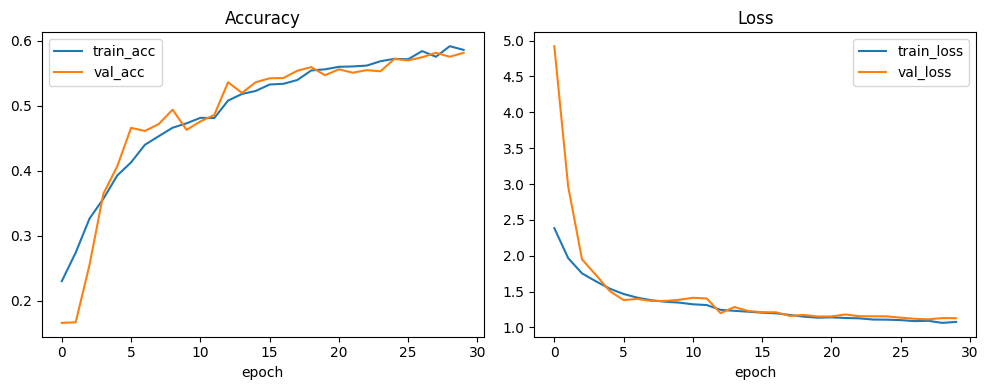

In [19]:
def plot_history(hist, savepath=HISTORY_PLOT):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(hist.history['accuracy'], label='train_acc')
    plt.plot(hist.history['val_accuracy'], label='val_acc')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'], label='train_loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.tight_layout()
    plt.savefig(savepath)
    plt.show()

plot_history(history)

#### Evaluate

37/37 ━━━━━━━━━━━━━━━━━━━━ 23s 571ms/step
              precision    recall  f1-score   support

           0       0.57      0.54      0.55       405
           1       0.48      0.36      0.41       369
           2       0.77      0.79      0.78       394
           3       0.51      0.39      0.44       396
           4       0.71      0.80      0.76       376
           5       0.48      0.68      0.57       386

    accuracy                           0.59      2326
   macro avg       0.59      0.59      0.58      2326
weighted avg       0.59      0.59      0.59      2326



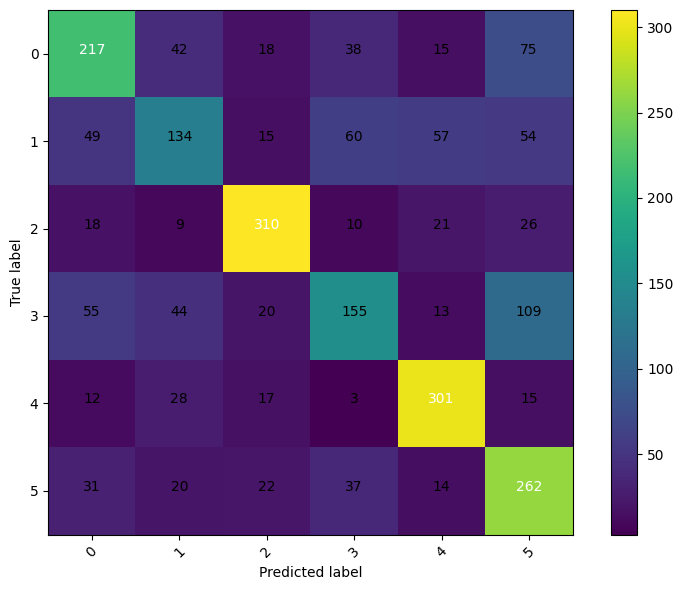

In [20]:
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
pred_probs = model.predict(test_generator, steps=test_steps, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes

idx_to_class = {v:k for k,v in train_generator.class_indices.items()}
print(classification_report(y_true, y_pred, target_names=[idx_to_class[i] for i in range(num_classes)]))

cm = confusion_matrix(y_true, y_pred)
def plot_confusion_matrix(cm, classes, normalize=False, savepath=CONF_MATRIX_PLOT):
    plt.figure(figsize=(8,6))
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt), ha='center', color='white' if cm[i,j]>thresh else 'black')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(savepath)
    plt.show()

plot_confusion_matrix(cm, [idx_to_class[i] for i in range(num_classes)], normalize=False)